# 线性回归

## 详细实现

In [21]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [22]:
# 生成合成数据
def synthetic_data(w, b, num_examples):
    '''
    生成线性回归的特征和标签
    w: 模型参数
    b: 模型偏置
    num_examples: 生成样本数量
    '''
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成正态分布的特征
    y = torch.matmul(X, w) + b  # 计算线性回归的标签
    y += torch.normal(0, 0.01, y.shape)  # 添加噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
# 打印第一个样本的特征和标签
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.3608, -1.7893]) 
label: tensor([9.5651])


Text(0.5, 1.0, 'Feature 2 vs Label')

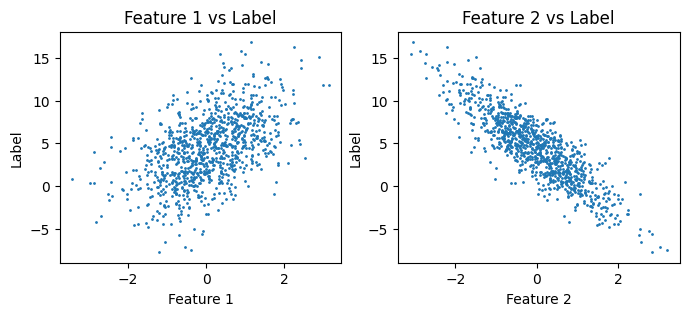

In [24]:
# 绘制特征和标签的散点图
fig, axs = d2l.plt.subplots(1, 2, figsize=(8, 3))
axs[0].scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1)
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Label')
axs[0].set_title('Feature 1 vs Label')
axs[1].scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
axs[1].set_xlabel('Feature 2')
axs[1].set_ylabel('Label')
axs[1].set_title('Feature 2 vs Label')

In [25]:
# 批量读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成长度为特征个数的列表indices
    random.shuffle(indices)  # 打乱indices的顺序
    for i in range(0, num_examples, batch_size):
        # 每次取出一个batch_size大小的数据，并防止越界
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[j], labels[j]
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6526,  0.5547],
        [-0.1939,  1.4976],
        [ 2.1871,  0.2285],
        [-0.9059,  2.0024],
        [ 1.8242,  0.5639],
        [-0.8849, -0.2517],
        [-0.3290,  0.8033],
        [-0.4633,  0.3402],
        [-1.1154, -0.5109],
        [ 2.2850,  0.4033]]) 
 tensor([[ 3.6016],
        [-1.2775],
        [ 7.8010],
        [-4.4114],
        [ 5.9252],
        [ 3.2790],
        [ 0.8029],
        [ 2.1113],
        [ 3.7307],
        [ 7.3908]])


***yield***的作用可以概括为:
- 将一个函数转换成一个生成器,实现流式数据读取。

具体来说,使用***yield***的函数有以下特点:
- 不再一次返回所有结果,而是每次调用next()时返回一个数据块。
- 函数内部状态会被保存,用于生成下一个数据块。
- 可以通过for循环等方式获取生成的数据流。
- 函数执行时更加节省内存,适合处理大量数据。
- 数据读取顺序可以通过函数内部逻辑控制,实现更复杂的读取逻辑。

In [26]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w, '\n', b)

tensor([[ 0.0116],
        [-0.0106]], requires_grad=True) 
 tensor([0.], requires_grad=True)


In [27]:
# 定义线性回归模型
def Linreg(X, w, b):
    return torch.matmul(X, w) + b

In [28]:
# 定义均方损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [29]:
# 定义小批量随机梯度下降算法
def sgd(params, lr, batch_size):
    # 关闭autograd
    with torch.no_grad():
        # 循环更新每个参数
        for param in params:
            # 参数更新,梯度下降 lr是学习率
            param -= lr * param.grad / batch_size
            # 清零梯度
            param.grad.zero_()

- 在PyTorch中,对tensor的操作默认会构建计算图,以支持自动求导计算梯度(autograd)。
    - 但在模型参数更新的时候,我们只需要执行操作,不需要计算图和梯度。
    - 如果保持默认autograd状态,会导致:
        - 构建临时计算图,占用额外CPU和GPU算力。
        - 计算图占用额外内存。
        - Requires Gradient标志被保留在参数tensor中。
        - 每次参数更新都会触发autograd引擎。

In [30]:
lr = 0.01
num_epochs = 10
# 初始化网络和损失函数
net = Linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 前向传播:传入batch数据,计算loss
        l = loss(net(X, w, b), y)
        # 反向传播:loss.backward()计算loss关于参数的梯度,loss.sum()为了获得标量,才能调用backward
        l.sum().backward()
        # 调用优化函数sgd,更新参数——sgd依据梯度、lr等更新w,b
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        # 计算训练集上的loss
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 2.101166
epoch 2, loss 0.254834
epoch 3, loss 0.030934
epoch 4, loss 0.003785
epoch 5, loss 0.000498
epoch 6, loss 0.000101
epoch 7, loss 0.000052
epoch 8, loss 0.000046
epoch 9, loss 0.000045
epoch 10, loss 0.000045


In [31]:
# 输出参数的估计误差——true_*是生成数据时设置的真实值,*是训练得到的预测值
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001,  0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


## 简洁实现

In [32]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# 调用函数生成特征和标签
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [34]:
def load_array(data_arrays, batch_size, is_train=True):
    # 使用TensorDataset封装数据
    dataset = data.TensorDataset(*data_arrays)
    # 创建DataLoader进行batch加载
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
# 生成DataLoader对象
data_iter = load_array((features, labels), batch_size)
# 读取第一个batch
next(iter(data_iter))

[tensor([[ 1.4483, -0.9200],
         [-1.2930, -0.2407],
         [ 1.1767, -0.0411],
         [-0.8797,  0.4294],
         [-0.6150, -0.1397],
         [-0.4849, -1.3212],
         [ 1.6166, -1.0187],
         [-0.2216,  2.4678],
         [ 0.6459,  2.0001],
         [-0.9471,  0.2660]]),
 tensor([[10.2433],
         [ 2.4334],
         [ 6.7033],
         [ 0.9796],
         [ 3.4614],
         [ 7.7350],
         [10.8984],
         [-4.6186],
         [-1.3033],
         [ 1.4117]])]

In [35]:
from torch import nn
# 定义一个线性回归的神经网络——nn.Sequential()将网络层组合到一个序列容器中
net = nn.Sequential(nn.Linear(2, 1))

In [36]:
# 初始化网络参数——单层网络只能初始化第一层
# 权重用小的正态分布初始化
net[0].weight.data.normal_(0, 0.01)
# 偏置初始化为0
net[0].bias.data.fill_(0)

tensor([0.])

In [37]:
# 使用MSELoss作为损失函数
loss = nn.MSELoss()
# 使用SGD（随机梯度下降）优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [38]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        # 前向传播:传入输入计算loss
        l = loss(net(X), y)
        # 反向传播:计算loss关于参数的梯度
        trainer.zero_grad()
        l.backward()
        # 使用优化器更新权重
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch:{epoch + 1}, loss: {l:f}')

epoch:1, loss: 0.000176
epoch:2, loss: 0.000101
epoch:3, loss: 0.000101


In [39]:
# 输出参数的估计误差——true_*是生成数据时设置的真实值,*是训练得到的预测值
print(f'w的估计误差: {true_w - list(net.parameters())[0].reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - list(net.parameters())[1]}')


w的估计误差: tensor([-0.0004, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)
